# [Deep Factors with Gaussian Process for Forecasting](https://arxiv.org/pdf/1812.00098.pdf)

## 1 Gaussian process in TensorFlow

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

input_dim = 1

train_input_holder = tf.placeholder(tf.float32, [None,input_dim],name='train_inpput')
train_output_holder = tf.placeholder(tf.float32, [None,1],name='train_output')
test_input_holder = tf.placeholder(tf.float32, [None,input_dim],name='test_inpput')

kernel_parameter = 0.1
# kernel for train data
tile_1_train = tf.tile(tf.expand_dims(train_input_holder, 0), [tf.shape(train_input_holder)[0], 1, 1])
tile_2_train = tf.tile(tf.expand_dims(train_input_holder, 1), [1, tf.shape(train_input_holder)[0], 1])
dist_train = tf.reduce_sum(tf.square(tf.subtract(tile_1_train, tile_2_train)), 2)

Kernel_train = tf.exp(-0.5*dist_train*1/kernel_parameter)

# kernel for test data
tile_1_test = tf.tile(tf.expand_dims(test_input_holder, 0), [tf.shape(test_input_holder)[0], 1, 1])
tile_2_test = tf.tile(tf.expand_dims(test_input_holder, 1), [1, tf.shape(test_input_holder)[0], 1])
dist_test = tf.reduce_sum(tf.square(tf.subtract(tile_1_test, tile_2_test)), 2)

Kernel_test = tf.exp(-0.5*dist_test*1/kernel_parameter)

# kernel for test-train
tile_train = tf.tile(tf.expand_dims(train_input_holder, 0), [tf.shape(test_input_holder)[0], 1, 1])
tile_test = tf.tile(tf.expand_dims(test_input_holder, 1), [1, tf.shape(train_input_holder)[0], 1])
dist_tt = tf.reduce_sum(tf.square(tf.subtract(tile_train, tile_test)), 2)

Kernel_tt = tf.exp(-0.5*dist_tt*1/kernel_parameter)

mu = tf.matmul(tf.matmul((Kernel_tt),tf.linalg.inv(Kernel_train)),train_output_holder)
var = Kernel_test-tf.matmul(tf.matmul(Kernel_tt,tf.linalg.inv(Kernel_train)),tf.transpose(Kernel_tt))

sess = tf.Session()
Xtrain = np.array([-4, -3, -2, -1, 1,2,3]).reshape(7,1)
Ytrain = np.sin(Xtrain)*2.
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)
mu_,var_=sess.run([mu,var],feed_dict={train_input_holder:Xtrain,train_output_holder:Ytrain,test_input_holder:Xtest})

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

input_dim = 1

train_input_holder = tf.placeholder(tf.float32, [None,input_dim],name='train_inpput')
train_output_holder = tf.placeholder(tf.float32, [None,1],name='train_output')
test_input_holder = tf.placeholder(tf.float32, [None,input_dim],name='test_inpput')

kernel_parameter = 0.1
# kernel for train data
tile_1_train = tf.tile(tf.expand_dims(train_input_holder, 0), [tf.shape(train_input_holder)[0], 1, 1])
tile_2_train = tf.tile(tf.expand_dims(train_input_holder, 1), [1, tf.shape(train_input_holder)[0], 1])
dist_train = tf.reduce_sum(tf.square(tf.subtract(tile_1_train, tile_2_train)), 2)

Kernel_train = tf.exp(-0.5*dist_train*1/kernel_parameter)

# kernel for test data
tile_1_test = tf.tile(tf.expand_dims(test_input_holder, 0), [tf.shape(test_input_holder)[0], 1, 1])
tile_2_test = tf.tile(tf.expand_dims(test_input_holder, 1), [1, tf.shape(test_input_holder)[0], 1])
dist_test = tf.reduce_sum(tf.square(tf.subtract(tile_1_test, tile_2_test)), 2)

Kernel_test = tf.exp(-0.5*dist_test*1/kernel_parameter)

# kernel for test-train
tile_train = tf.tile(tf.expand_dims(train_input_holder, 0), [tf.shape(test_input_holder)[0], 1, 1])
tile_test = tf.tile(tf.expand_dims(test_input_holder, 1), [1, tf.shape(train_input_holder)[0], 1])
dist_tt = tf.reduce_sum(tf.square(tf.subtract(tile_train, tile_test)), 2)

Kernel_tt = tf.exp(-0.5*dist_tt*1/kernel_parameter)

mu = tf.matmul(tf.matmul((Kernel_tt),tf.linalg.inv(Kernel_train)),train_output_holder)
var = Kernel_test-tf.matmul(tf.matmul(Kernel_tt,tf.linalg.inv(Kernel_train)),tf.transpose(Kernel_tt))

sess = tf.Session()
Xtrain = np.array([-4, -3, -2, -1, 1,2,3]).reshape(7,1)
Ytrain = np.sin(Xtrain)*2.
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)
mu_,var_=sess.run([mu,var],feed_dict={train_input_holder:Xtrain,train_output_holder:Ytrain,test_input_holder:Xtest})

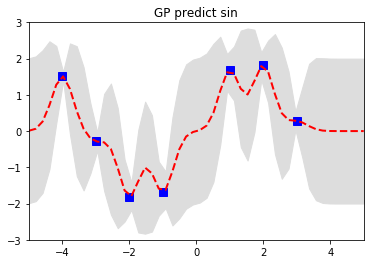

In [60]:
plt.plot(Xtrain, Ytrain, 'bs', ms=8)
stdv = np.sqrt(np.array(var_).diagonal())
mu_ = mu_.reshape(-1)
plt.gca().fill_between(Xtest.flat, mu_-2*stdv, mu_+2*stdv, color="#dddddd")
plt.plot(Xtest, mu_, 'r--', lw=2)
plt.axis([-5, 5, -3, 3])
plt.title('GP predict sin')
plt.show()

## 2 Method implementation

In [1]:
import numpy as np
import tensorflow as tf
import scipy.io
import tensorly as ts
import os
import matplotlib.pyplot as plt
os.chdir("G:/jupyter/Guangzhou-data-set")
tensor = scipy.io.loadmat('tensor.mat')
tensor = tensor['tensor']
tensor = np.array(tensor)
print(tensor.shape)
tensor = tensor.reshape(214,-1)
print(tensor.shape)

def weight_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)
def bias_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)

Using numpy backend.


(214, 61, 144)
(214, 8784)


### 2.1 Single road segment test

In [57]:
# global effect
class rnn_global():
    def __init__(self,input_len=6):
        self.input_len = input_len
        self.input_holder = tf.placeholder(tf.float32, [None,input_len])
    
    def build_network(self,h_size=12,out_size=12):
        state_input = tf.reshape(self.input_holder, (-1,self.input_len,1))
        cell = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
        hidden_state=cell.zero_state(1 , tf.float32) 
        rnn,rnn_state = tf.nn.dynamic_rnn(\
                inputs=state_input,cell=cell,dtype=tf.float32,initial_state=hidden_state)

        w1 = weight_variable([h_size,out_size])
        b1 = bias_variable([out_size])
        rnn = tf.reshape(rnn,shape=[-1,h_size])
        global_pred = tf.nn.tanh(tf.matmul(rnn,w1)+b1)
        global_pred = tf.reshape(global_pred,(-1,self.input_len*out_size))
        
        return global_pred
    
# characterization of each time series
class model_t():
    def __init__(self,  input_len=6):
        self.train_input_holder = tf.placeholder(tf.float32, [None,input_len],name='train_inpput')
        self.train_output_holder = tf.placeholder(tf.float32, [None,input_len],name='train_output')
        self.input_len = input_len
        self.batch_size = tf.placeholder(tf.int32)
 
        
    def gp_random_effect(self,):
        kernel_parameter = weight_variable([1])
        self.w_sigma = weight_variable([self.input_len,self.input_len])
        
        # kernel for train data

        tile_1_train = tf.tile(tf.expand_dims(self.train_input_holder , 0), [tf.shape(self.train_input_holder)[0], 1, 1])
        tile_2_train = tf.tile(tf.expand_dims(self.train_input_holder , 1), [1, tf.shape(self.train_input_holder)[0], 1])
        dist_train = tf.reduce_sum(tf.square(tf.subtract(tile_1_train, tile_2_train)), 2)

        self.Kernel = tf.exp(-0.5*dist_train*1/kernel_parameter)

        # sample local fluctuation
        mask = tf.eye(self.input_len)
        self.w_sigma =  tf.multiply(self.w_sigma,mask)
        self.r = tf.matmul(self.Kernel,self.w_sigma) # r~GP(0,sigma^2) ==>r = 0+sigma*randn

            
        return self.r,self.Kernel
    
    def global_pattern_atn(self, latent, out_size=12):
        w1 = weight_variable([out_size*self.input_len,self.input_len])
        self.f = tf.identity(tf.matmul(latent,w1))
        return self.f
    
    def pred(self,):
        self.sigma = self.Kernel + self.w_sigma**2
        self.normal_dist = tf.distributions.Normal(self.f, tf.sqrt(self.sigma))
        self.prediction = self.f
        self.prob = (self.normal_dist.prob(self.train_output_holder))
        self.loss = tf.reduce_sum(self.normal_dist.log_prob(self.train_output_holder))
        self.mse = tf.reduce_sum(tf.squared_difference(self.prediction,self.train_output_holder))
        return self.loss


tf.reset_default_graph()
sess = tf.Session()
# train procedure
global_model = rnn_global(input_len=100)
g = global_model.build_network()

characters=[]
network_size=1
for i in range(network_size):
    characters = model_t(input_len=100)
    r,K = characters.gp_random_effect()
    g_ = characters.global_pattern_atn(g)
    loss_ = characters.pred()

train_Op = tf.train.AdadeltaOptimizer(learning_rate=-0.05).minimize(loss_)

In [58]:
sess.run(tf.global_variables_initializer())
max_episode = 800
for i in range(max_episode):
    l,lh,mse, _=sess.run([loss_,characters.prob,characters.mse,train_Op], feed_dict={global_model.input_holder:[tensor[0,0:100]], 
                                              characters.train_input_holder: [tensor[0,0:100]],
                                              characters.train_output_holder:[tensor[0,1:101]]})
    if i%100==0:
        print('mle loss: %g mse:%g'%(l,mse))

mle loss: -7.69264e+06 mse:153683
mle loss: -7.51402e+06 mse:150110
mle loss: -6.59968e+06 mse:131823
mle loss: -334622 mse:6509.3
mle loss: -12735.1 mse:70.9116
mle loss: -9219.51 mse:0.592559
mle loss: -9190.03 mse:0.00189806
mle loss: -9192.55 mse:0.0536805


### 2.2 Network test

In [72]:
# global effect
class rnn_global():
    def __init__(self,input_len=6):
        self.input_len = input_len
        self.input_holder = tf.placeholder(tf.float32, [None,input_len])
    
    def build_network(self,h_size=12,out_size=12):
        state_input = tf.reshape(self.input_holder, (-1,self.input_len,1))
        cell = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
        hidden_state=cell.zero_state(214 , tf.float32) 
        rnn,rnn_state = tf.nn.dynamic_rnn(\
                inputs=state_input,cell=cell,dtype=tf.float32,initial_state=hidden_state)

        w1 = weight_variable([h_size,out_size])
        b1 = bias_variable([out_size])
        rnn = tf.reshape(rnn,shape=[-1,h_size])
        global_pred = tf.nn.tanh(tf.matmul(rnn,w1)+b1)
        global_pred = tf.reshape(global_pred,(-1,self.input_len*out_size))
        
        return global_pred
    
# characterization of each time series
class model_t():
    def __init__(self,  input_len=6):
        self.train_input_holder = tf.placeholder(tf.float32, [None,input_len],name='train_inpput')
        self.train_output_holder = tf.placeholder(tf.float32, [None,input_len],name='train_output')
        self.input_len = input_len
        self.batch_size = tf.placeholder(tf.int32)
 
        
    def gp_random_effect(self,):
        kernel_parameter = weight_variable([1])
        self.w_sigma = weight_variable([self.input_len,self.input_len])
        
        # kernel for train data

        tile_1_train = tf.tile(tf.expand_dims(self.train_input_holder , 0), [tf.shape(self.train_input_holder)[0], 1, 1])
        tile_2_train = tf.tile(tf.expand_dims(self.train_input_holder , 1), [1, tf.shape(self.train_input_holder)[0], 1])
        dist_train = tf.reduce_sum(tf.square(tf.subtract(tile_1_train, tile_2_train)), 2)

        self.Kernel = tf.exp(-0.5*dist_train*1/kernel_parameter)

        # sample local fluctuation
        mask = tf.eye(self.input_len)
        self.w_sigma =  tf.multiply(self.w_sigma,mask)
        self.r = tf.matmul(self.Kernel,self.w_sigma) # r~GP(0,sigma^2) ==>r = 0+sigma*randn

            
        return self.r,self.Kernel
    
    def global_pattern_atn(self, latent, out_size=12,index=0):
        w1 = weight_variable([out_size*self.input_len,self.input_len])
        self.f = tf.identity(tf.matmul([latent[index,:]],w1))
        return self.f
    
    def pred(self,):

        self.sigma = self.Kernel + self.w_sigma**2
        self.normal_dist = tf.distributions.Normal(self.f, tf.sqrt(self.sigma))
        self.prediction = self.f
        self.prob = (self.normal_dist.prob(self.train_output_holder))
        self.loss = tf.reduce_sum(self.normal_dist.log_prob(self.train_output_holder))
        self.mse = tf.reduce_sum(tf.squared_difference(self.prediction,self.train_output_holder))
        return self.mse


tf.reset_default_graph()
sess = tf.Session()
# train procedure
global_model = rnn_global(input_len=100)
g = global_model.build_network()

characters=[]
network_size=214
loss_set=[]
characters=[]
feed_dict={global_model.input_holder:tensor[:,0:100]}
for i in range(network_size):
    characters.append(model_t(input_len=100))
    r,K = characters[-1].gp_random_effect()
    g_ = characters[-1].global_pattern_atn(g)
    loss_set.append( characters[-1].pred())
    feed_dict.update({characters[i].train_input_holder: [tensor[i,0:100]]})
    feed_dict.update({characters[i].train_output_holder:[tensor[i,1:101]]})
loss_ = tf.reduce_mean(loss_set)
train_Op = tf.train.AdadeltaOptimizer(learning_rate=0.05).minimize(loss_)

In [74]:
sess.run(tf.global_variables_initializer())
max_episode = 900
for i in range(max_episode):
    l,lh,mse, _=sess.run([loss_,characters[0].prob,characters[0].mse,train_Op], feed_dict=feed_dict)
    if i%100==0:
        print('mle loss: %g mse:%g'%(l,mse))

mle loss: 173817 mse:153898
mle loss: 141782 mse:122677
mle loss: 29160.3 mse:20771.6
mle loss: 6346.53 mse:3606.61
mle loss: 1400.25 mse:595.254
mle loss: 292.183 mse:78.9533
mle loss: 51.2483 mse:4.95104
mle loss: 6.28934 mse:0.0130209
mle loss: 0.408281 mse:1.45665e-08
